# 1. Import modules

In [1]:
import sys
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append("../")
from src.plot import donut_chart

plt.style.use("../../config/DIT_HAP.mplstyle")
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
AX_WIDTH, AX_HEIGHT = plt.rcParams['figure.figsize']

CATEGORY_COLOR_MAP = {
    "WT": COLORS[1],
    "small colonies": COLORS[1],
    "very small colonies": COLORS[1],
    "E": COLORS[0],
    "microcolonies": COLORS[0],
    "germinated": COLORS[0],
    "spores": COLORS[0],
    "Not verified": COLORS[-1]
}

DONUT_COLOR_MAP = {
    "spores": COLORS[7],
    "germinated": COLORS[0],
    "microcolonies": COLORS[-1],
    "E": COLORS[5],
    "very small colonies": COLORS[2],
    "small colonies": COLORS[4],
    "WT": COLORS[-4]
}

# 2.Configuration

In [2]:
@dataclass
class Config:

    project_dir: Path = Path("../../results/HD_DIT_HAP_generationRAW")

    @property
    def deletion_library_essentiality(self) -> pd.DataFrame:
        return pd.read_excel("../../resources/Hayles_2013_OB_merged_categories_sysIDupdated.xlsx")[["Updated_Systematic_ID", "One or multi basic phenotypes", "Category"]]

    @property
    def gene_level_result(self) -> pd.DataFrame:
        return pd.read_csv(self.project_dir / "17_gene_level_curve_fitting/gene_level_fitting_statistics.tsv", sep="\t")

    @property
    def verification_result(self) -> pd.DataFrame:
        verification = pd.read_excel("../../resources/verfication_results_summary.xlsx")
        verification = verification.dropna(subset=["Verified essentiality"])
        verification["Verification result"] = verification["Verification result"].replace(
            {
                "WT-like": "WT",
                "Very small colony": "very small colonies",
                "Small colony": "small colonies",
                "E, Very small colony": "E",
                "E & very small colonies": "E",
                "small colonies (unequal)": "small colonies",
                "very small colonies (unequal)": "very small colonies",
                "E, 2 & 3": "E",
                "Small colony, Very small colony": "small colonies",
                "leucine transporter?": "E"
            }
        )
        return verification

    def __post_init__(self):
        res = pd.merge(self.gene_level_result, self.deletion_library_essentiality, left_on="Systematic ID", right_on="Updated_Systematic_ID", how="left").drop(columns=["Updated_Systematic_ID"])
        res["Category_with_essentiality"] = res.apply(lambda row: f"{row['Category']} ({row['DeletionLibrary_essentiality']})" if row["Category"] == 'small colonies' and row["DeletionLibrary_essentiality"] == "E" else row["Category"], axis=1)
        self.merged_result = res.copy()

        self.output_dir = self.project_dir / "20_essentiality_verification"
        self.output_dir.mkdir(exist_ok=True, parents=True)

data_config = Config()

# 3. Data preparation

In [3]:
selected_categories = ["spores", "germinated", "microcolonies", "very small colonies", "small colonies", "WT"]
# selected_categories_with_essentiality = ["spores", "germinated", "microcolonies", "very small colonies", "small colonies", "WT"]

In [4]:
um_dict = data_config.merged_result.query("Category in @selected_categories").groupby("Category_with_essentiality")["um"].apply(list).to_dict()
um_dict = {
    "WT": um_dict["WT"],
    "small colonies": um_dict["small colonies"],
    "very small colonies": um_dict["very small colonies"],
    "microcolonies": um_dict["microcolonies"],
    "germinated": um_dict["germinated"],
    "spores": um_dict["spores"],
}

In [5]:
def prepare_verification_data(
    data_config: Config = data_config,
    outlier_filter_criteria: str = "Category == 'WT' and um > 0.35",
    table_title: str = "verification_data_WT_outliers.tsv"
) -> dict:
    """ Prepare verification data for outlier analysis. """

    outliers = data_config.merged_result.query(outlier_filter_criteria).sort_values(by="um", ascending=False)["Systematic ID"].unique().tolist()
    verified_outliers = data_config.verification_result.query("`Systematic ID` in @outliers").copy()
    verified_outlier_genes = verified_outliers["Systematic ID"].unique().tolist()
    missing_outlier_genes = [gene for gene in outliers if gene not in verified_outlier_genes]

    verification_results = {}
    verification_results["Not verified"] = missing_outlier_genes
    for category in ["WT", "small colonies", "very small colonies", "E", "microcolonies", "germinated", "spores"]:
        category_df = verified_outliers.query("`Verification result` == @category").copy()
        if not category_df.empty:
            verification_results[category] = category_df["Systematic ID"].unique().tolist()

    verification_genes_df = pd.DataFrame()
    for k, v in verification_results.items():
        sub_df = data_config.merged_result.query("`Systematic ID` in @v").copy()
        sub_df["Verification result"] = k
        verification_genes_df = pd.concat([verification_genes_df, sub_df], ignore_index=True)

    print("Outliers: ", verification_genes_df.shape[0])
    print("Verified_outliers: ", len(verified_outliers))
    print("Missing_outliers: ", len(missing_outlier_genes))

    um_dict = { k: data_config.merged_result.query("`Systematic ID` in @v")["um"].tolist() for k, v in verification_results.items() }

    verification_genes_df.to_csv(data_config.output_dir / table_title, sep="\t", index=False)

    return um_dict

# 4. Boxplot

In [6]:
def boxplot_with_violinplot(x, y, ax, colors):
    # Create violin plot
    parts = ax.violinplot(y, 
                         positions=range(len(x)),
                         showmeans=False, showmedians=False, showextrema=False, orientation="horizontal")
    
    # Style violin plots
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.6)
    
    # Create box plot
    box_parts = ax.boxplot(y, 
                          positions=range(len(x)),
                          widths=0.2, patch_artist=True, 
                          medianprops=dict(color='black', linewidth=2),
                          orientation="horizontal")

    for i, bp in enumerate(box_parts['boxes']):
        bp.set_facecolor(colors[i])
        bp.set_alpha(0.8)

    # Set x-axis labels
    ax.set_yticks(range(len(x)))
    tick_labels = [f"{l} (n={len(y[i])})" for i, l in enumerate(x)]
    ax.set_yticklabels(tick_labels, fontweight='bold')
    ax.tick_params(axis='y', which='minor', length=0)

def boxplot_with_violinplot_and_statistics(
    um_dict: dict,
    pdf_title: str
):
    """ Generate boxplot with violinplot and statistics text. """
    fig, axes = plt.subplots(1, 2, figsize=(2*AX_WIDTH, AX_HEIGHT), sharey=True, gridspec_kw={'width_ratios': [3, 1]})

    # Plot boxplot with violinplot on the first subplot
    EV_colors = [CATEGORY_COLOR_MAP[category] for category in um_dict.keys()]
    boxplot_with_violinplot(list(um_dict.keys()), list(um_dict.values()), axes[0], EV_colors)
    axes[0].set_title("Depletion Rate (DR)")
    axes[0].set_xlim(-0.3, 1.5)

    # Add statistics text to the second subplot
    for row, (category, category_ums) in enumerate(um_dict.items()):
        q1 = np.percentile(category_ums, 25)
        q3 = np.percentile(category_ums, 75)
        median = np.median(category_ums)
        mean = np.mean(category_ums)
        info = f"Q1={q1:.2f}, Median={median:.2f}, Q3={q3:.2f}, Mean={mean:.2f}"
        axes[1].text(1.05, row, info, va='center', ha='left', fontweight="bold")
    axes[1].axis('off')

    # Finalize and save the figure
    plt.savefig(data_config.output_dir / pdf_title, dpi=300)
    plt.show()
    plt.close()

## 4.1 Compare with deletion library

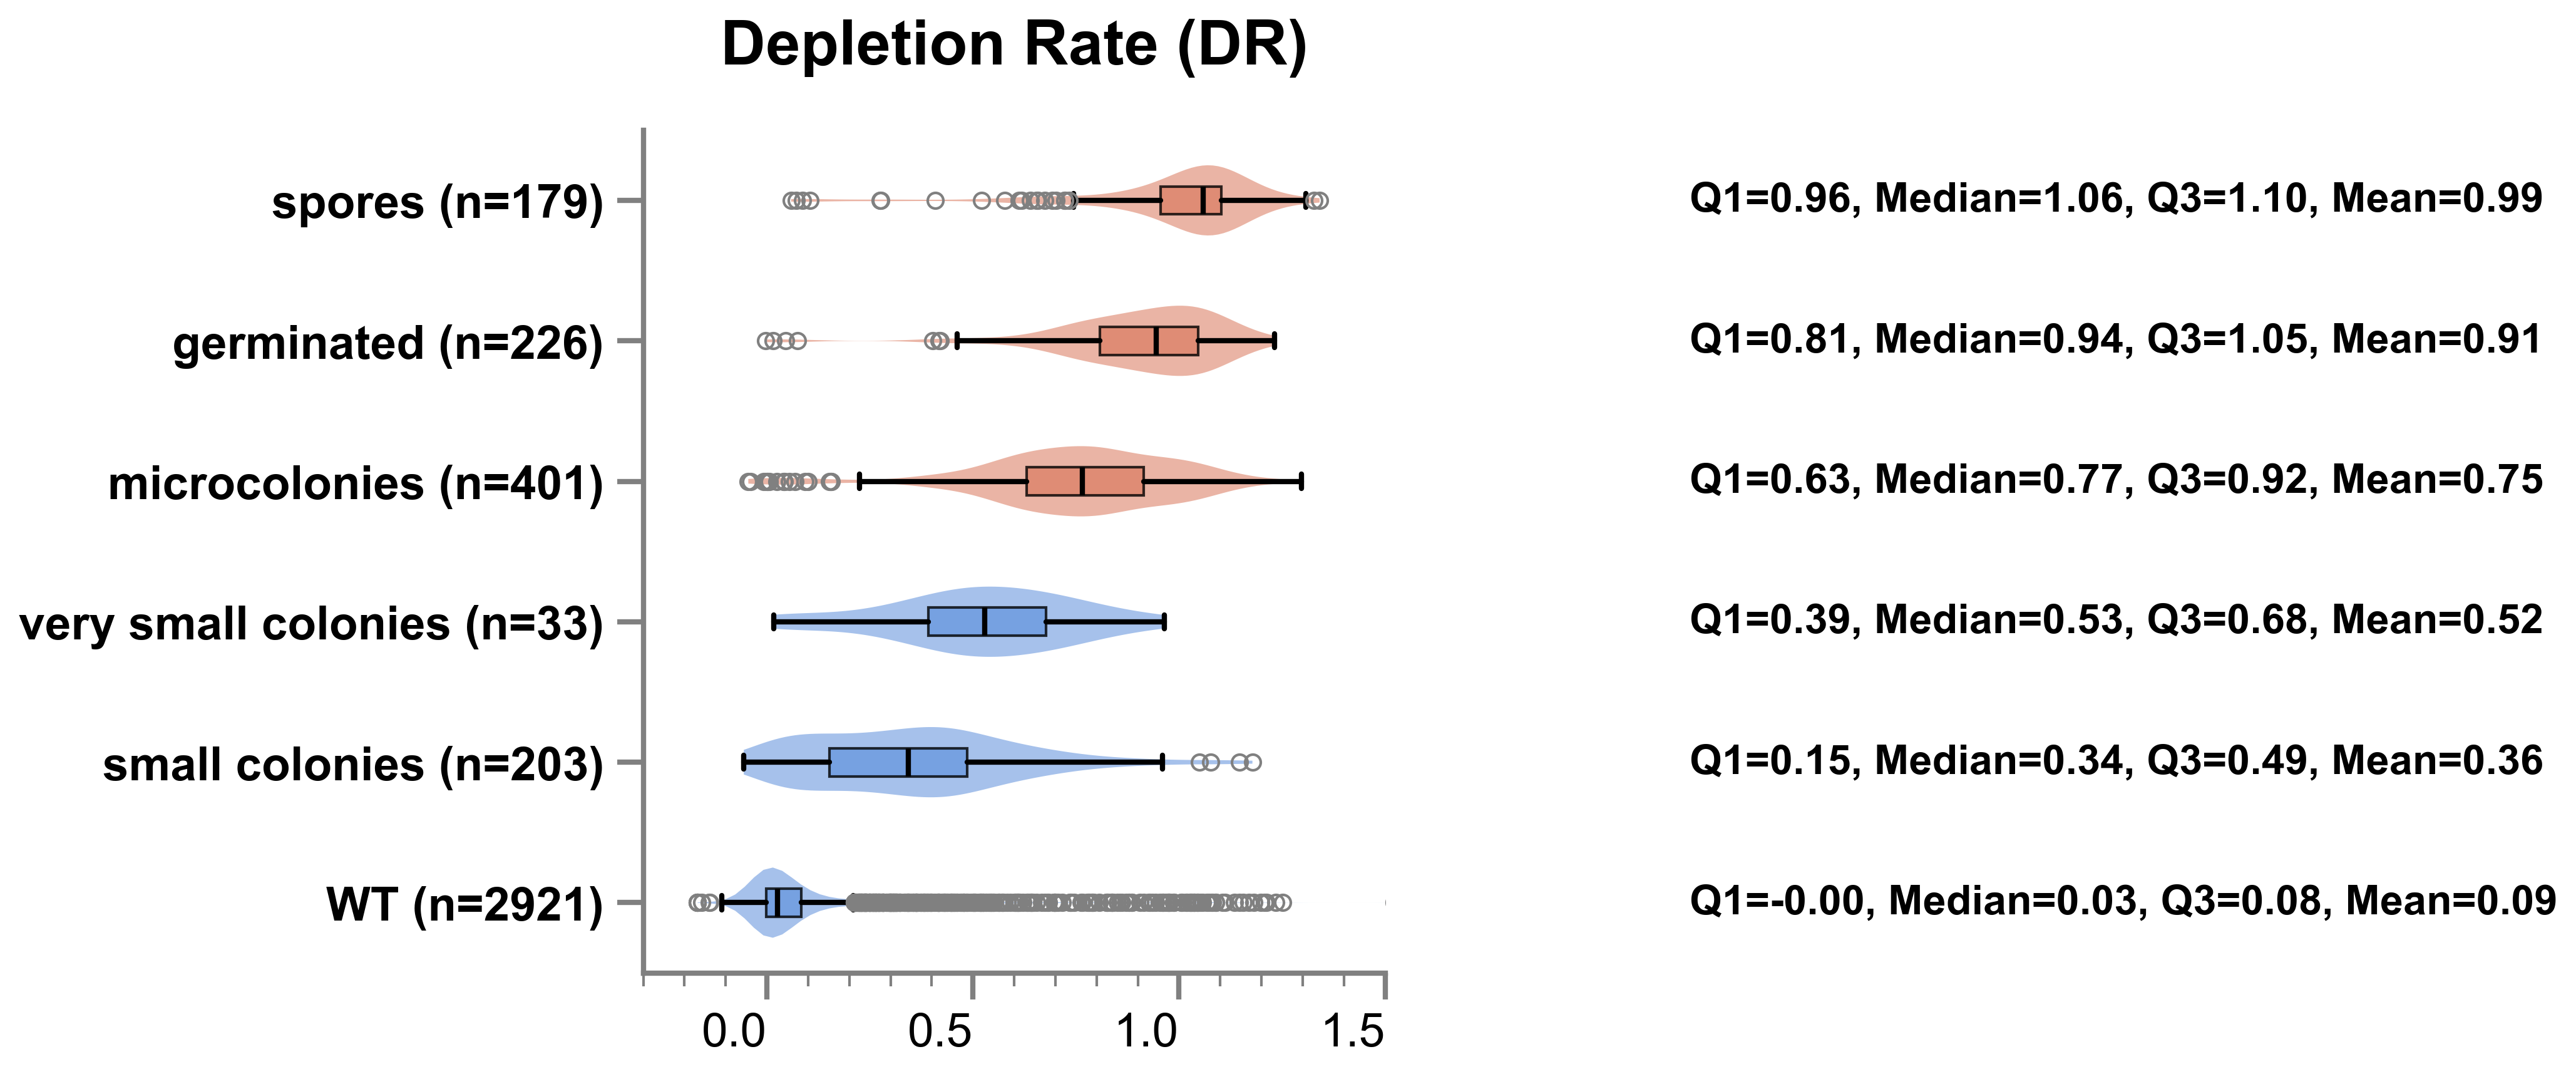

In [7]:
boxplot_with_violinplot_and_statistics(um_dict, "depletion_rate_comparison_with_deletion_library_summary.pdf")

## 4.2 Plot boxplots with WT2nonWT genes

Choose the WT category and select the genes with um greater than the median of small colonies (`~0.35`)

Outliers:  231
Verified_outliers:  145
Missing_outliers:  86


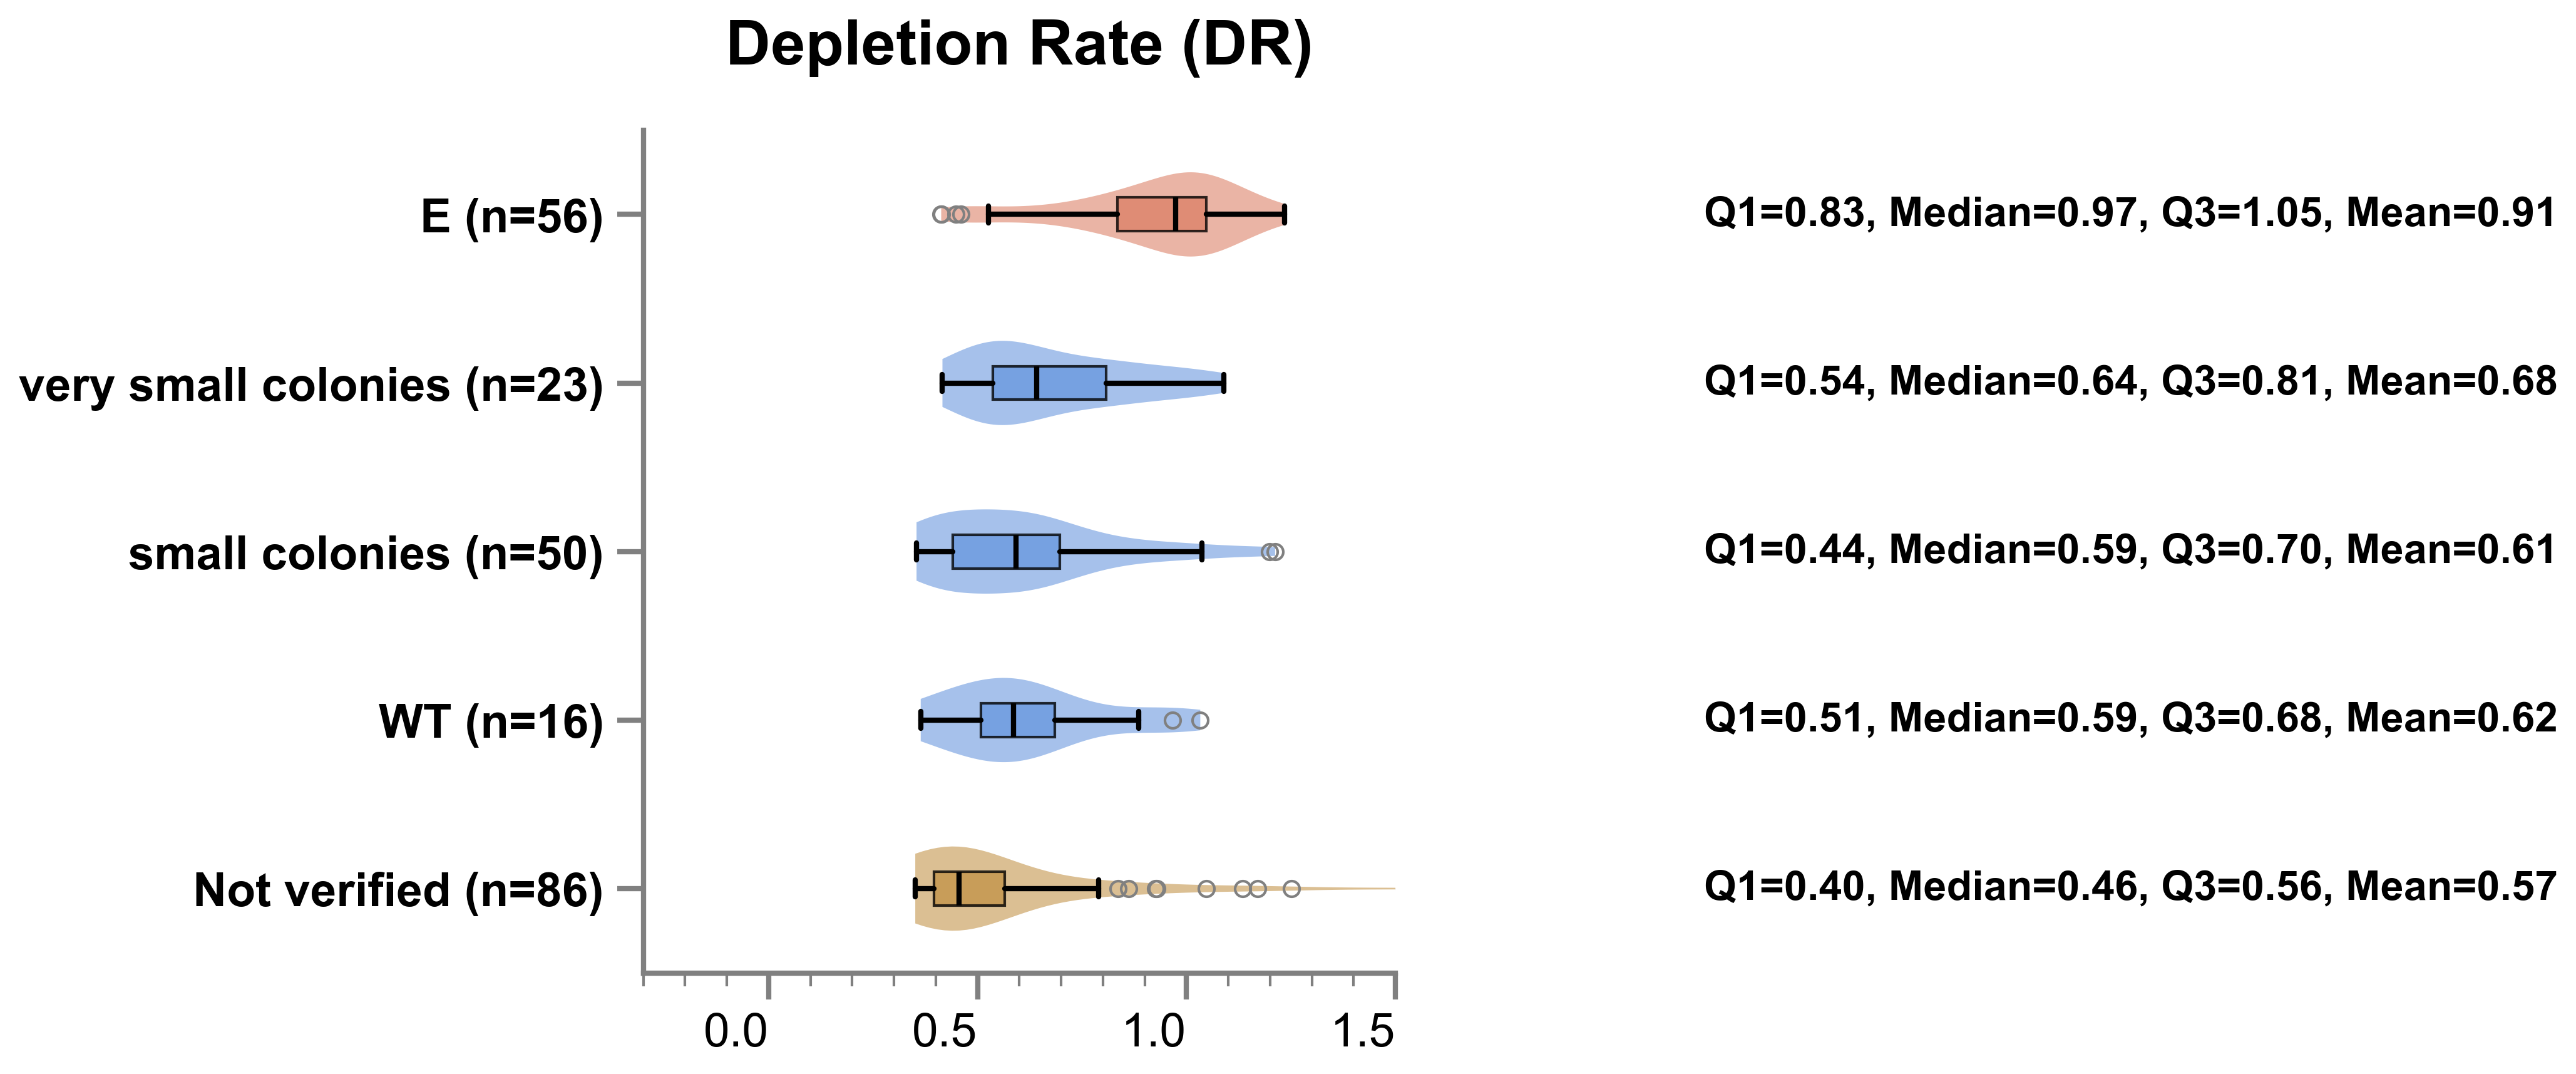

In [8]:
WT2nonWT_um_dict = prepare_verification_data(
    data_config=data_config,
    outlier_filter_criteria="Category == 'WT' and um > 0.35",
    table_title="WT2nonWT_genes_verification_summary.tsv",
)

boxplot_with_violinplot_and_statistics(WT2nonWT_um_dict, "WT2nonWT_verification_boxplot_violinplot.pdf")

## 4.3 small colonies2essential

Choose the small colonies category and select the genes with um greater than the median of the microcolonies (`~0.75`)

Outliers:  26
Verified_outliers:  9
Missing_outliers:  17


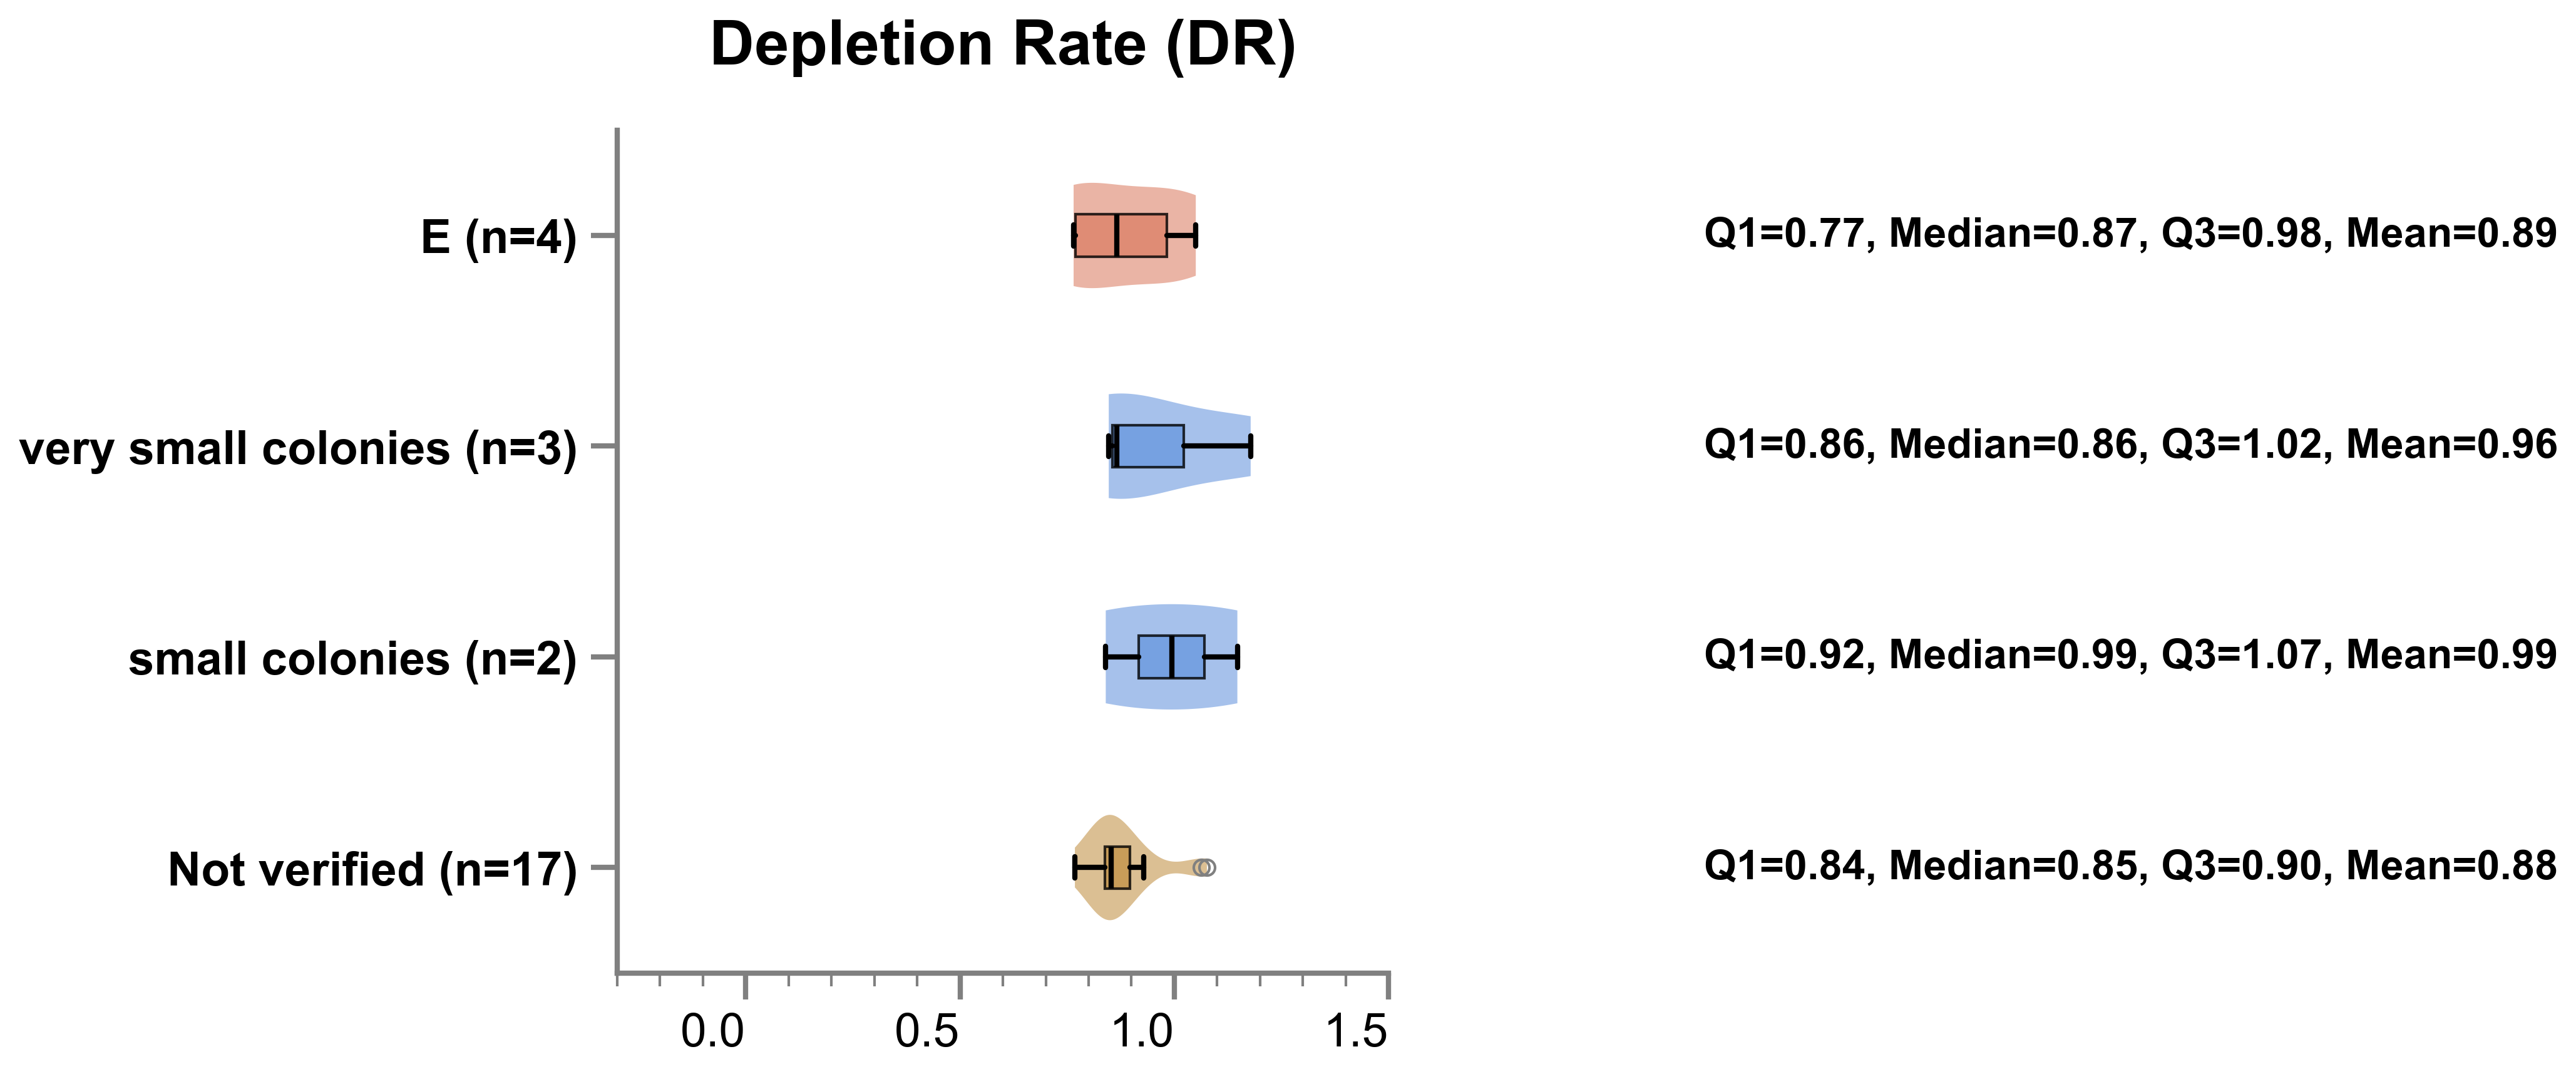

In [9]:
sc2E_um_dict = prepare_verification_data(
    data_config=data_config,
    outlier_filter_criteria="Category == 'small colonies' and um > 0.75",
    table_title="small_colonies_to_E_genes_verification_summary.tsv",
)
boxplot_with_violinplot_and_statistics(sc2E_um_dict, "small_colonies_to_E_verification_boxplot_violinplot.pdf")

## 4.4 E2V genes

Choose the essential category and select the genes with um less than the median of the small colonies (`~0.35`)

Outliers:  30
Verified_outliers:  8
Missing_outliers:  22


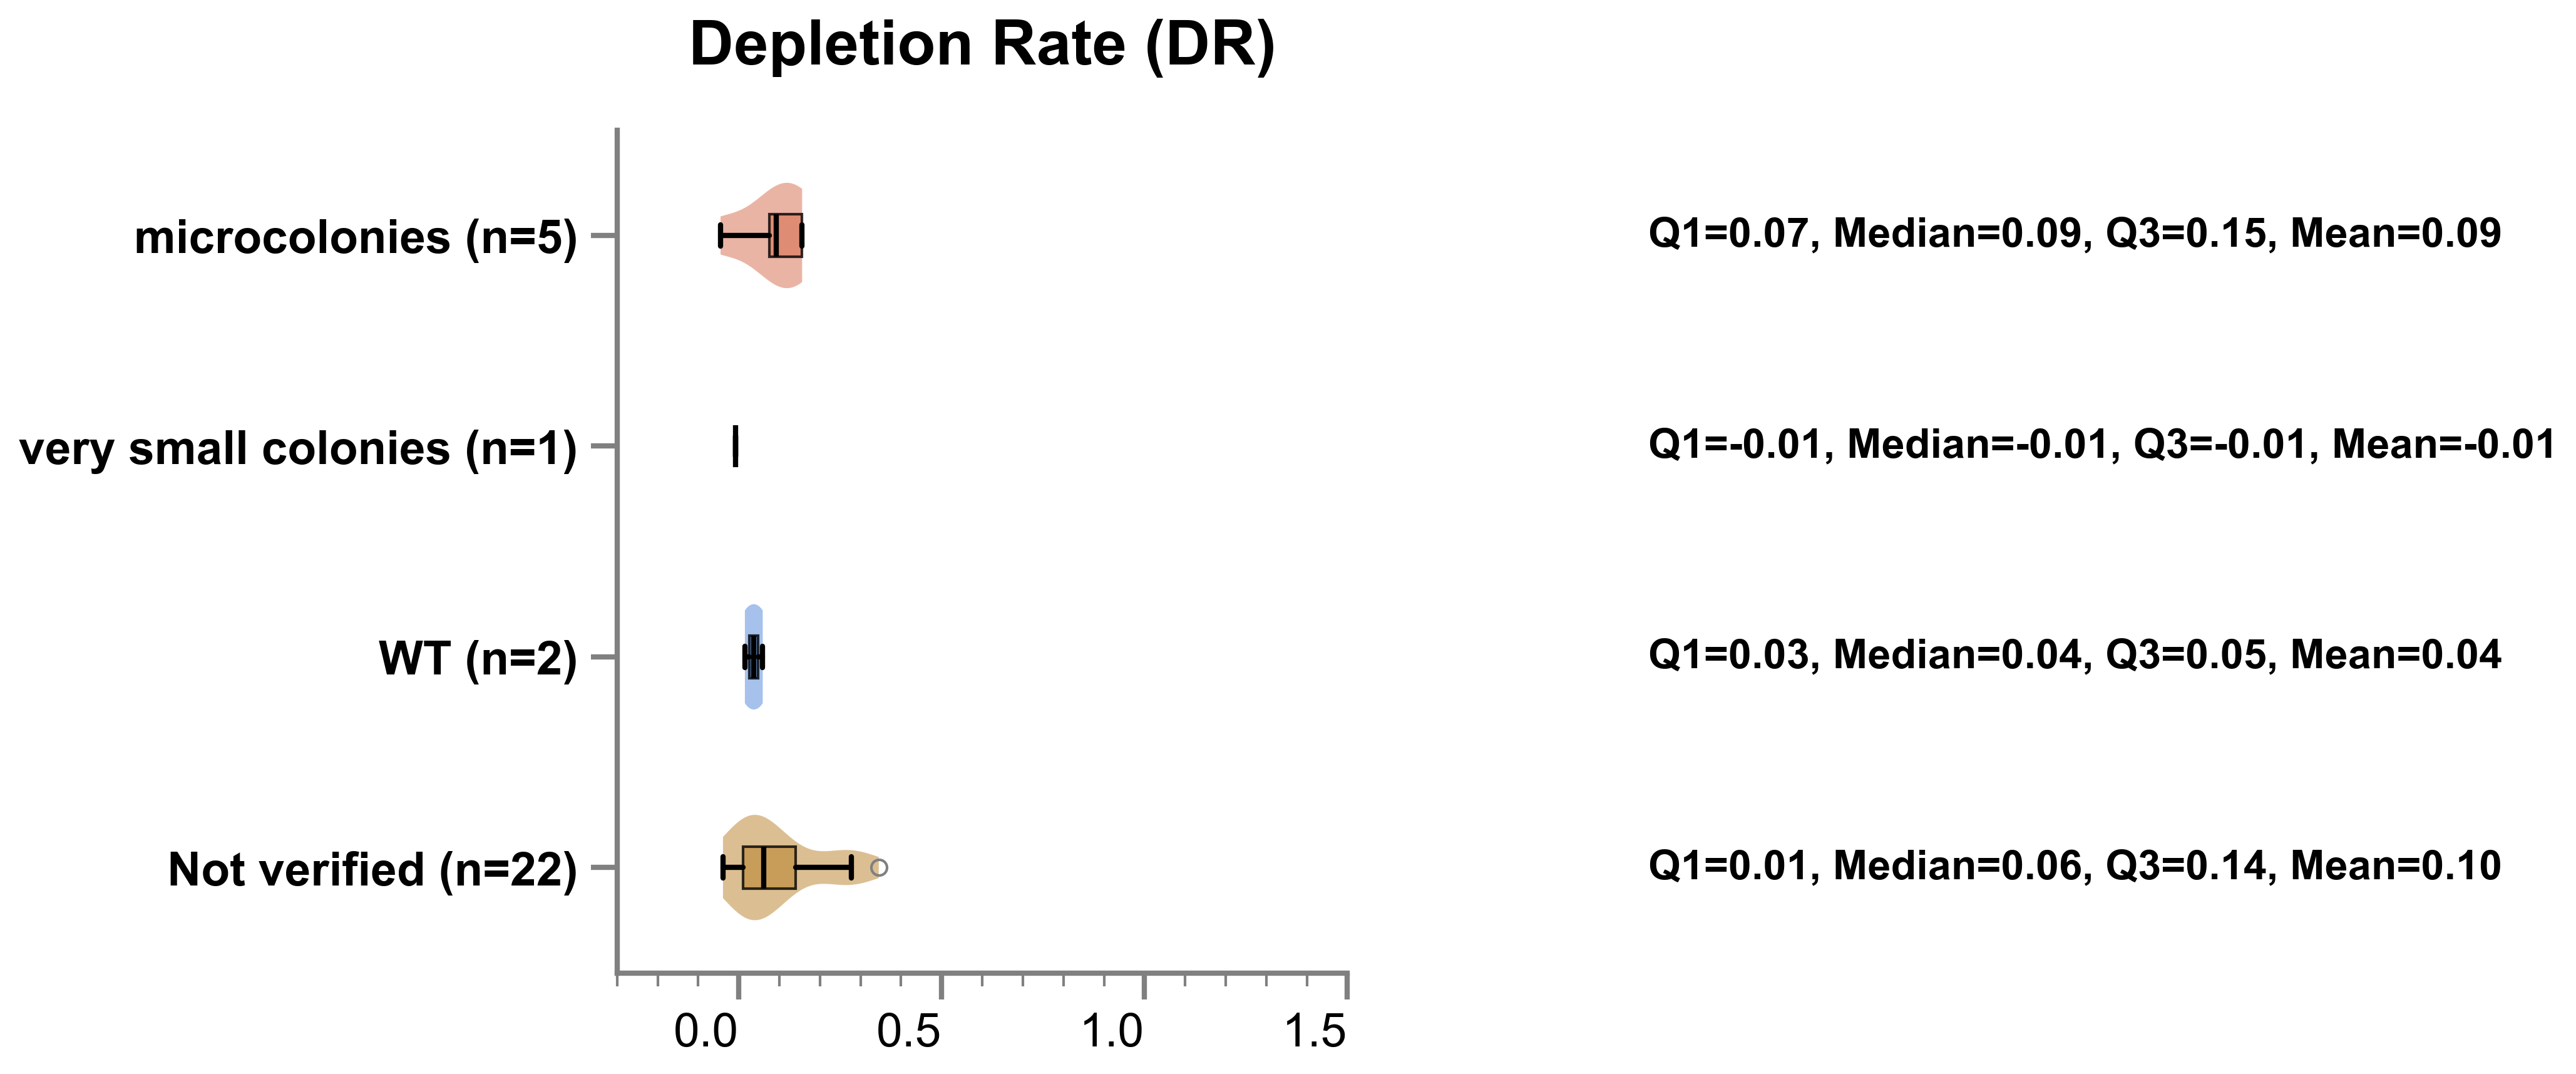

In [10]:
E_categories = [ "spores", "germinated", "microcolonies" ]
E2V_um_dict = prepare_verification_data(
    data_config=data_config,
    outlier_filter_criteria="Category in @E_categories and um < 0.35",
    table_title="E2V_genes_verification_summary.tsv",
)
boxplot_with_violinplot_and_statistics(E2V_um_dict, "E2V_verification_boxplot_violinplot.pdf")

# 5. Donut plot

In [16]:
label_orders = ["spores", "germinated", "microcolonies", "E", "very small colonies", "small colonies", "WT"]

def donut_chart_for_verification_results(um_dict: dict, pdf_title: str):
    """ Generate donut chart for verification results. """

    # prepare the labels and sizes
    sorted_um_dict = {k: um_dict[k] for k in label_orders if k in um_dict}
    sizes = [len(v) for v in sorted_um_dict.values()]
    labels = list(sorted_um_dict.keys())
    colors = [DONUT_COLOR_MAP[k] for k in labels]

    center_text = 'have been\nverified'

    # Create the donut chart
    donut_chart(sizes, labels, colors, center_text)

    plt.savefig(data_config.output_dir / pdf_title, dpi=300)
    plt.show()
    plt.close()

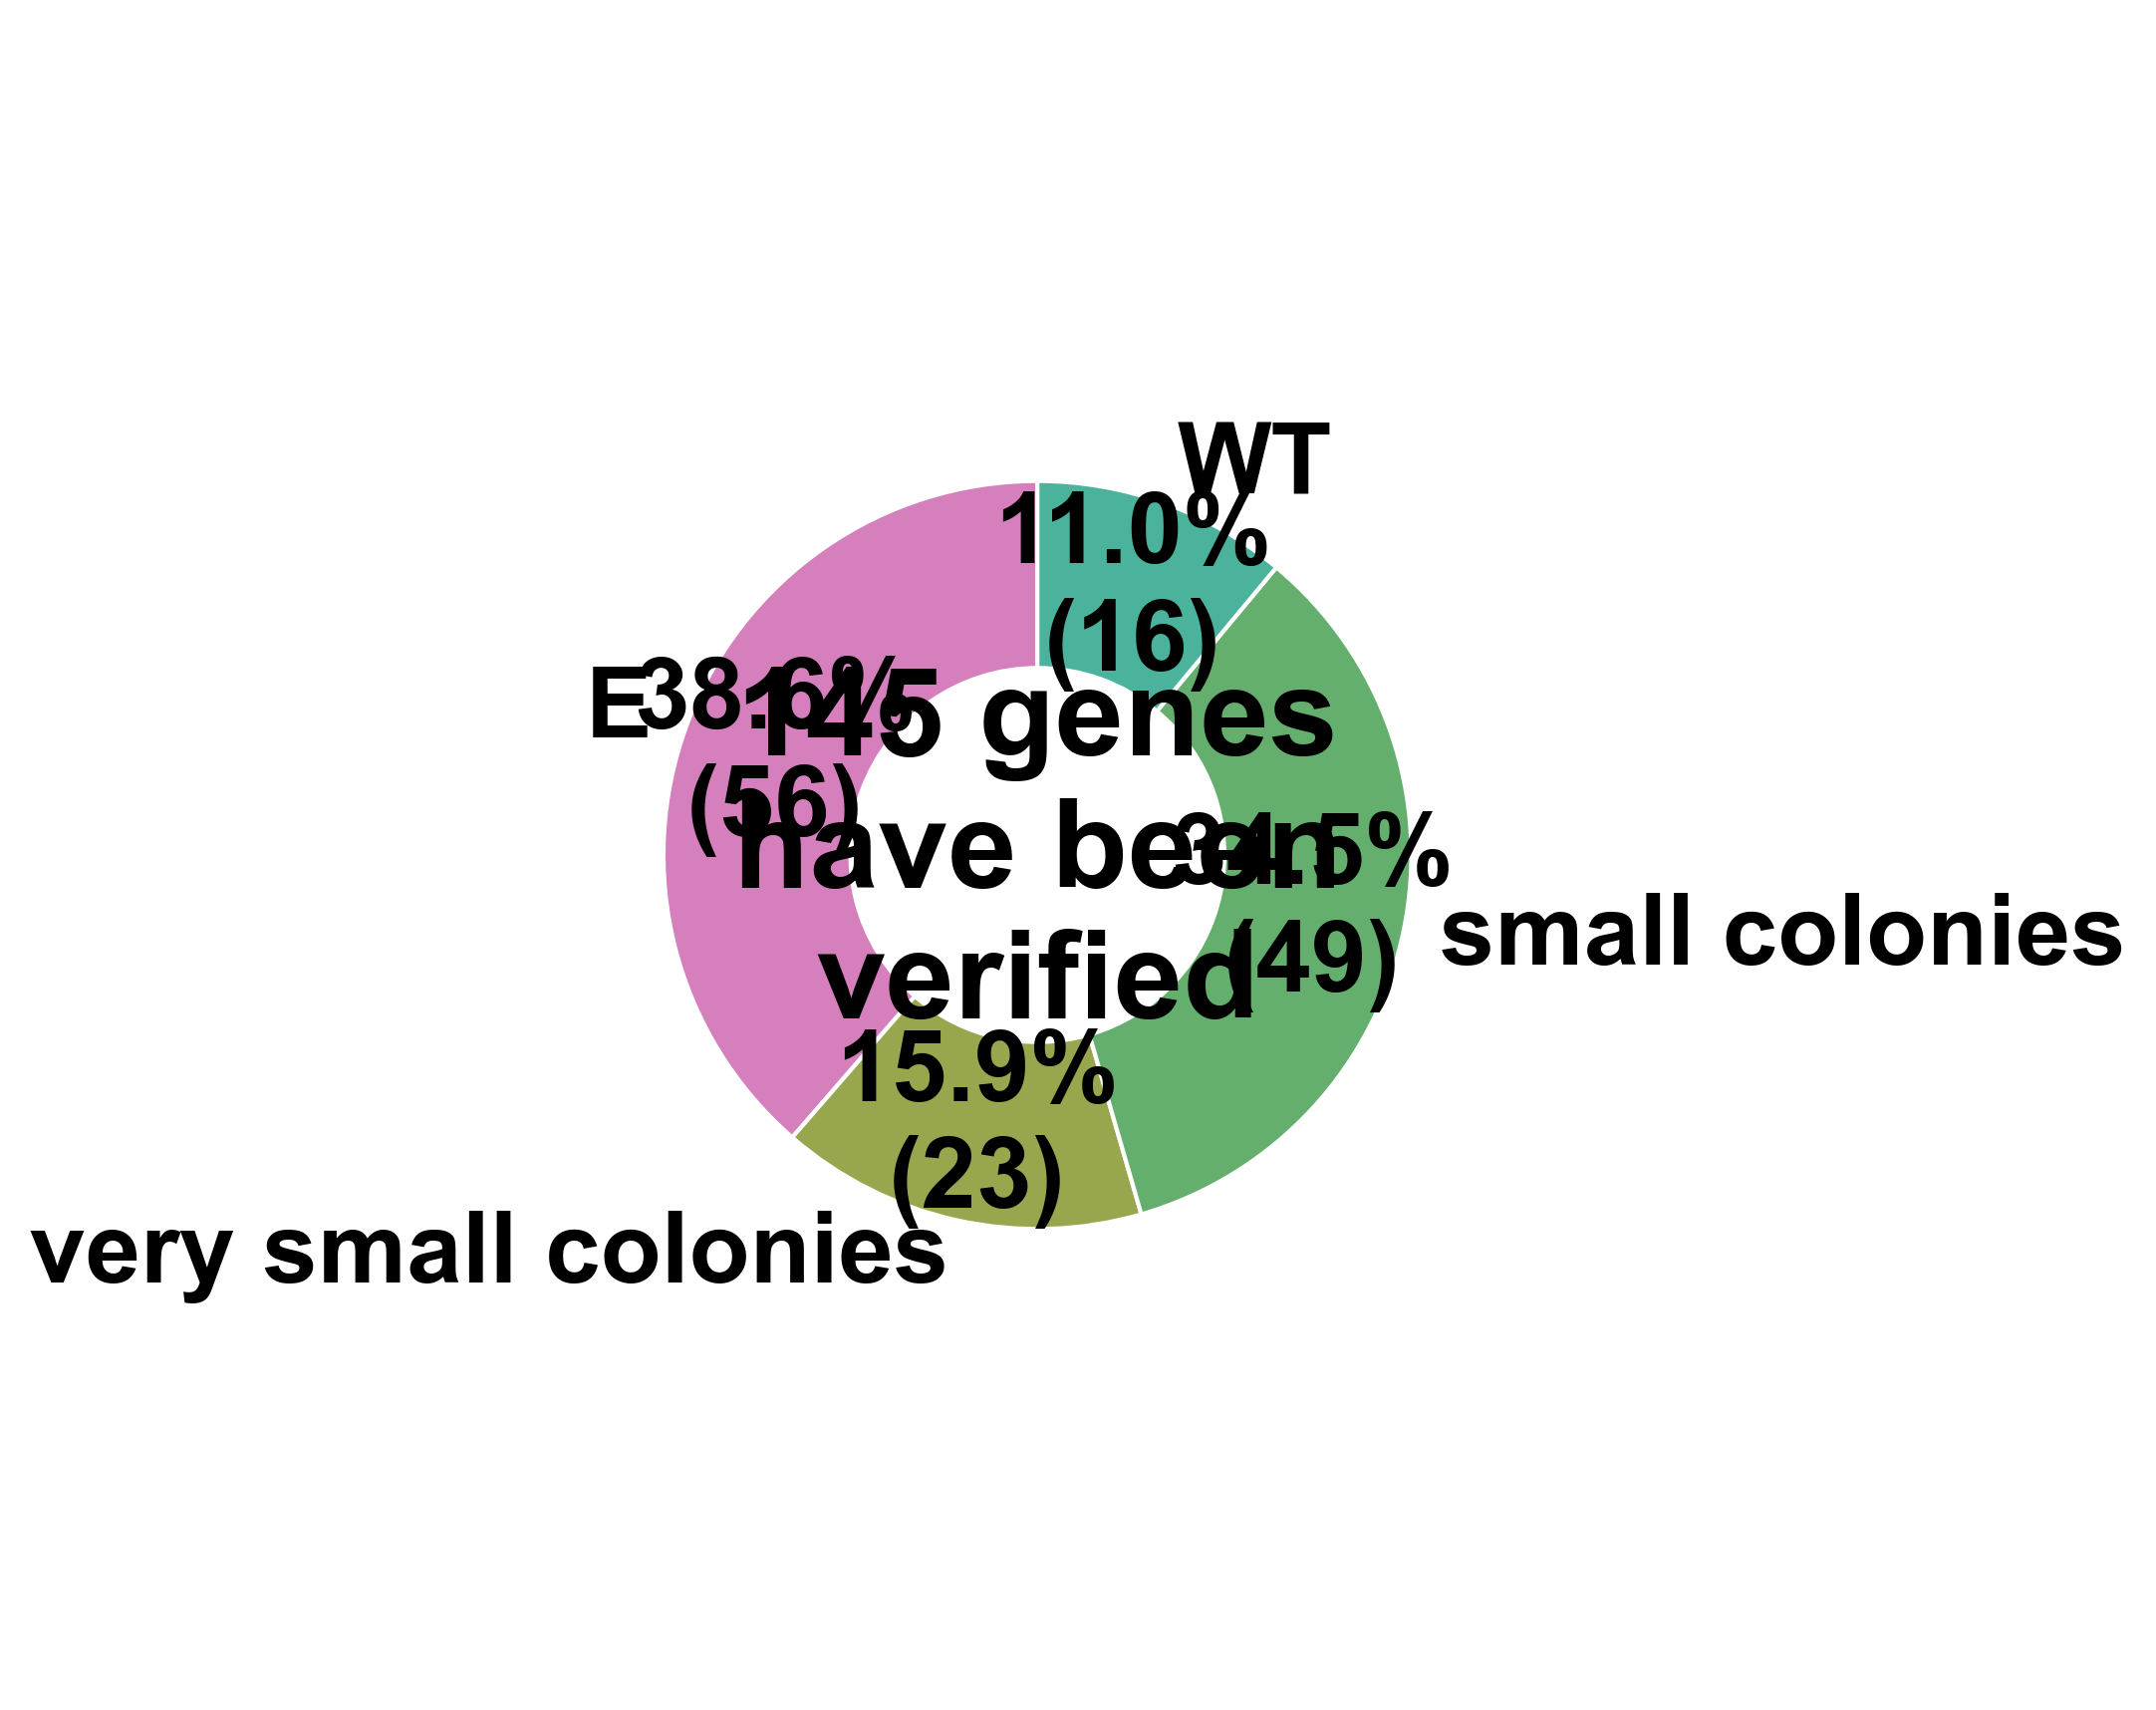

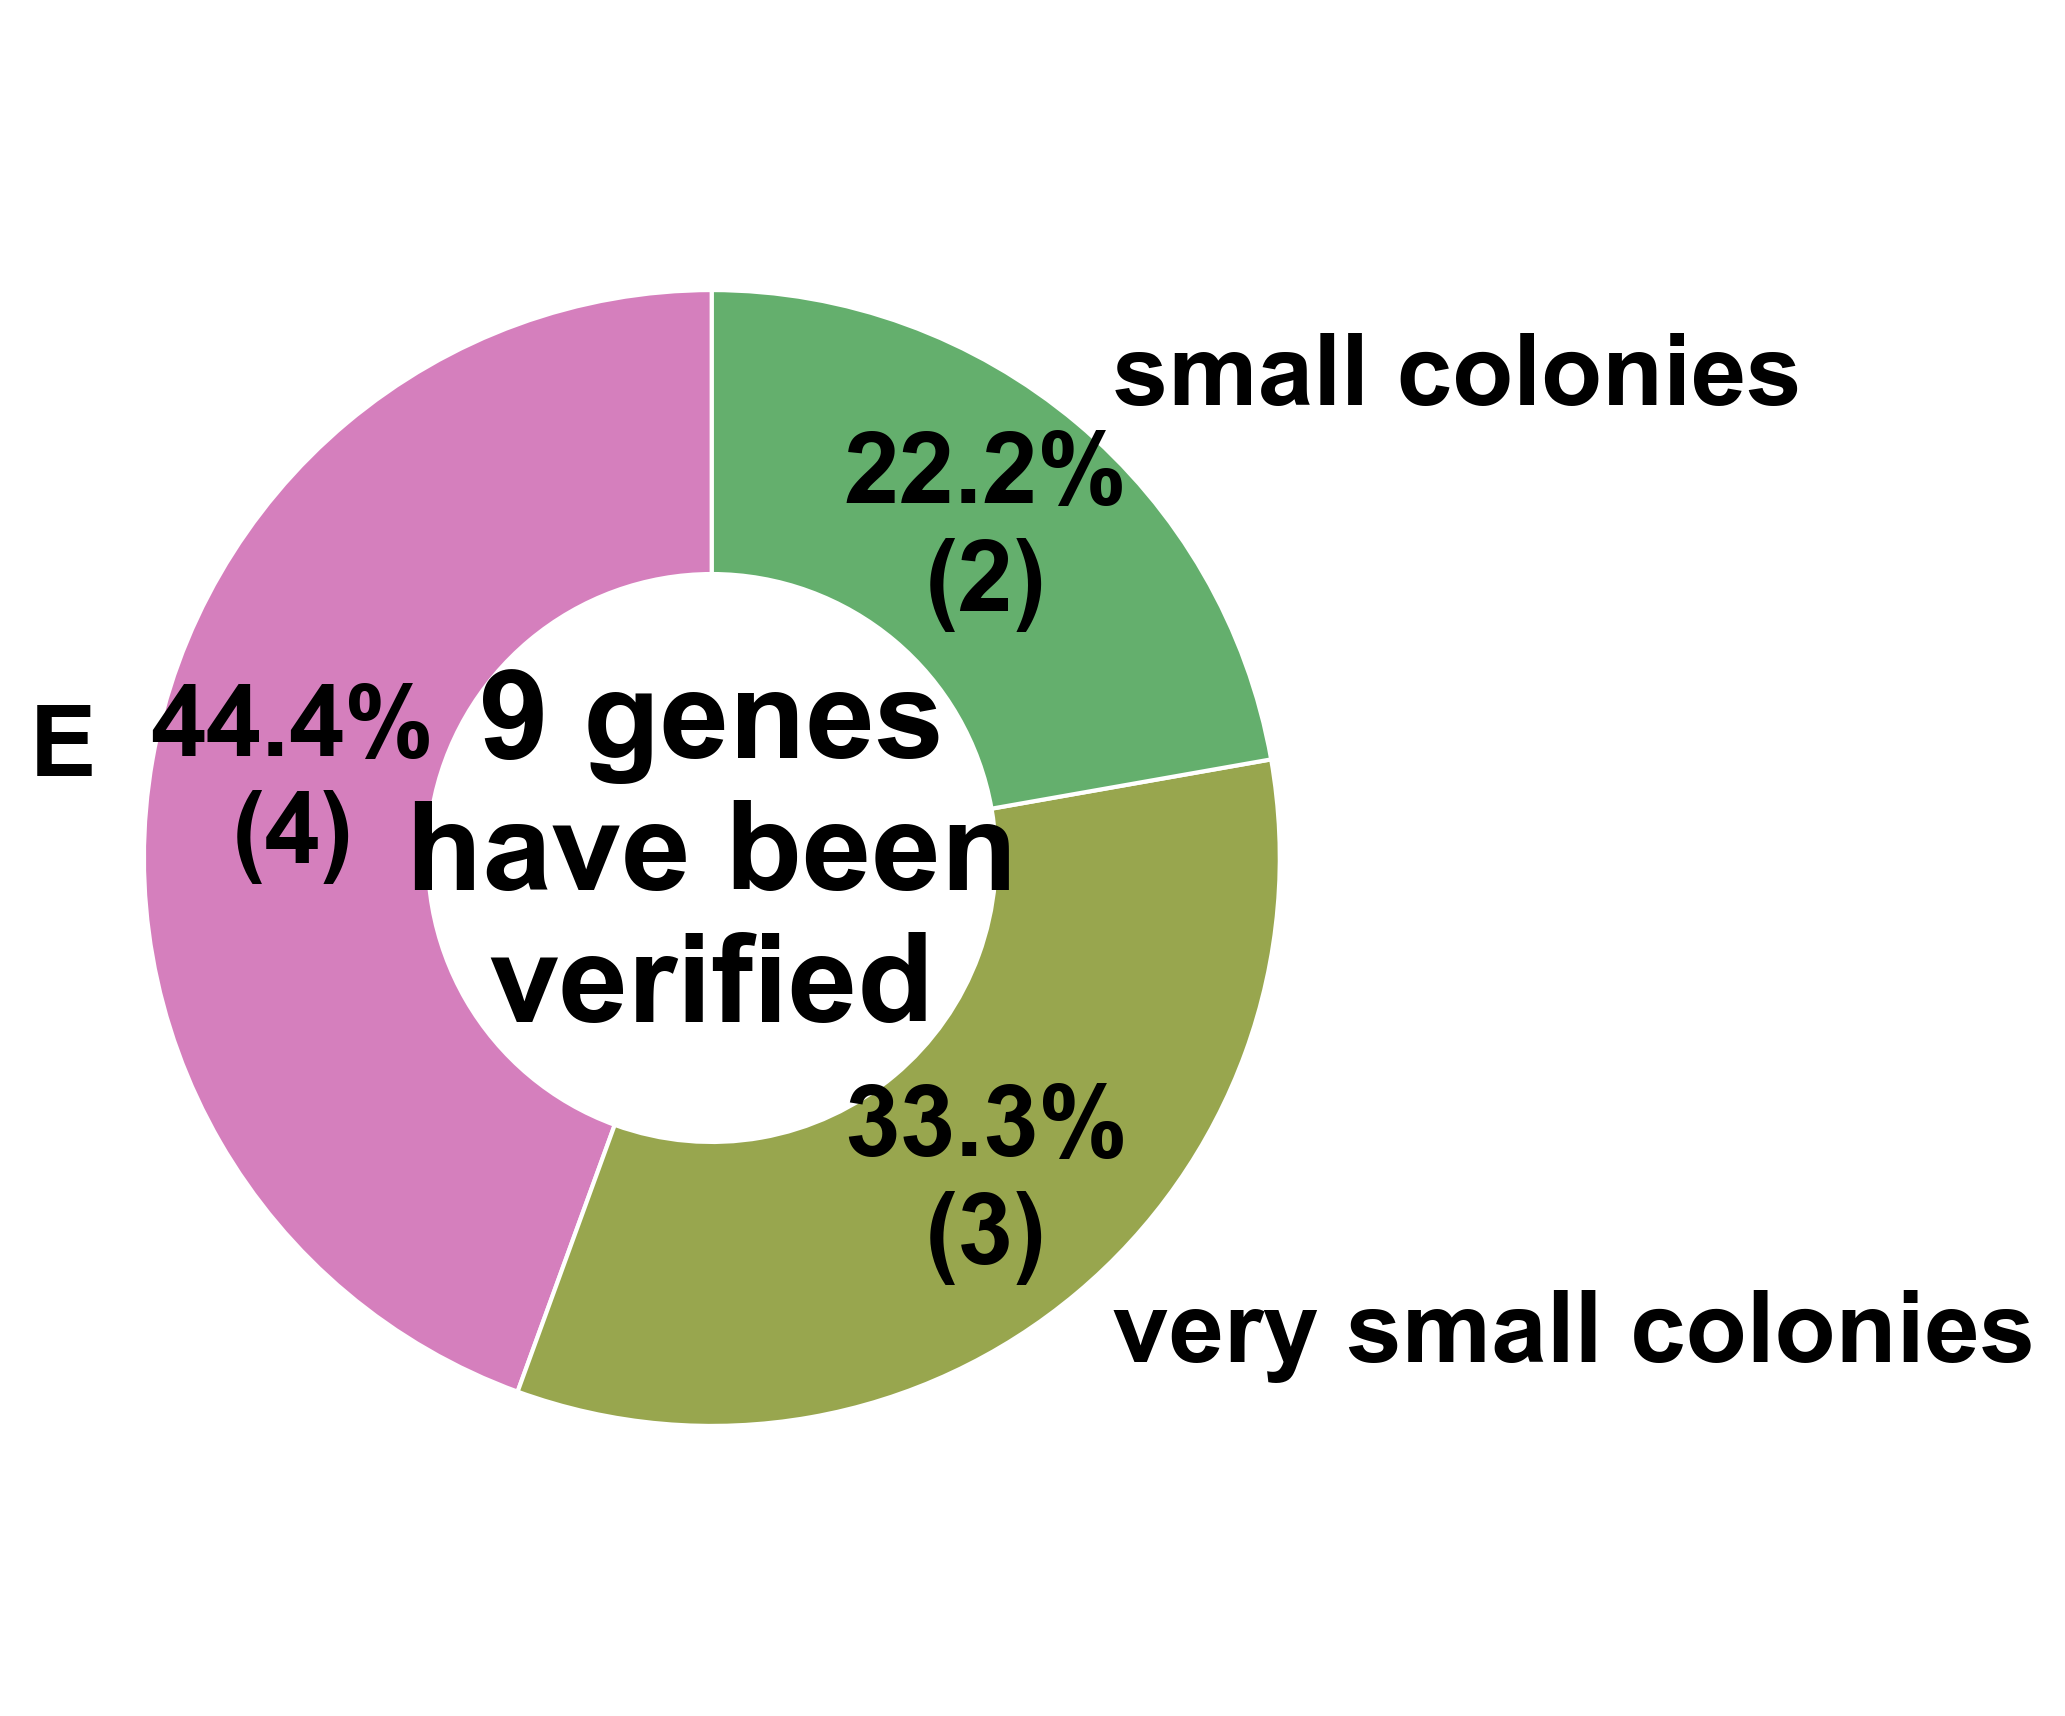

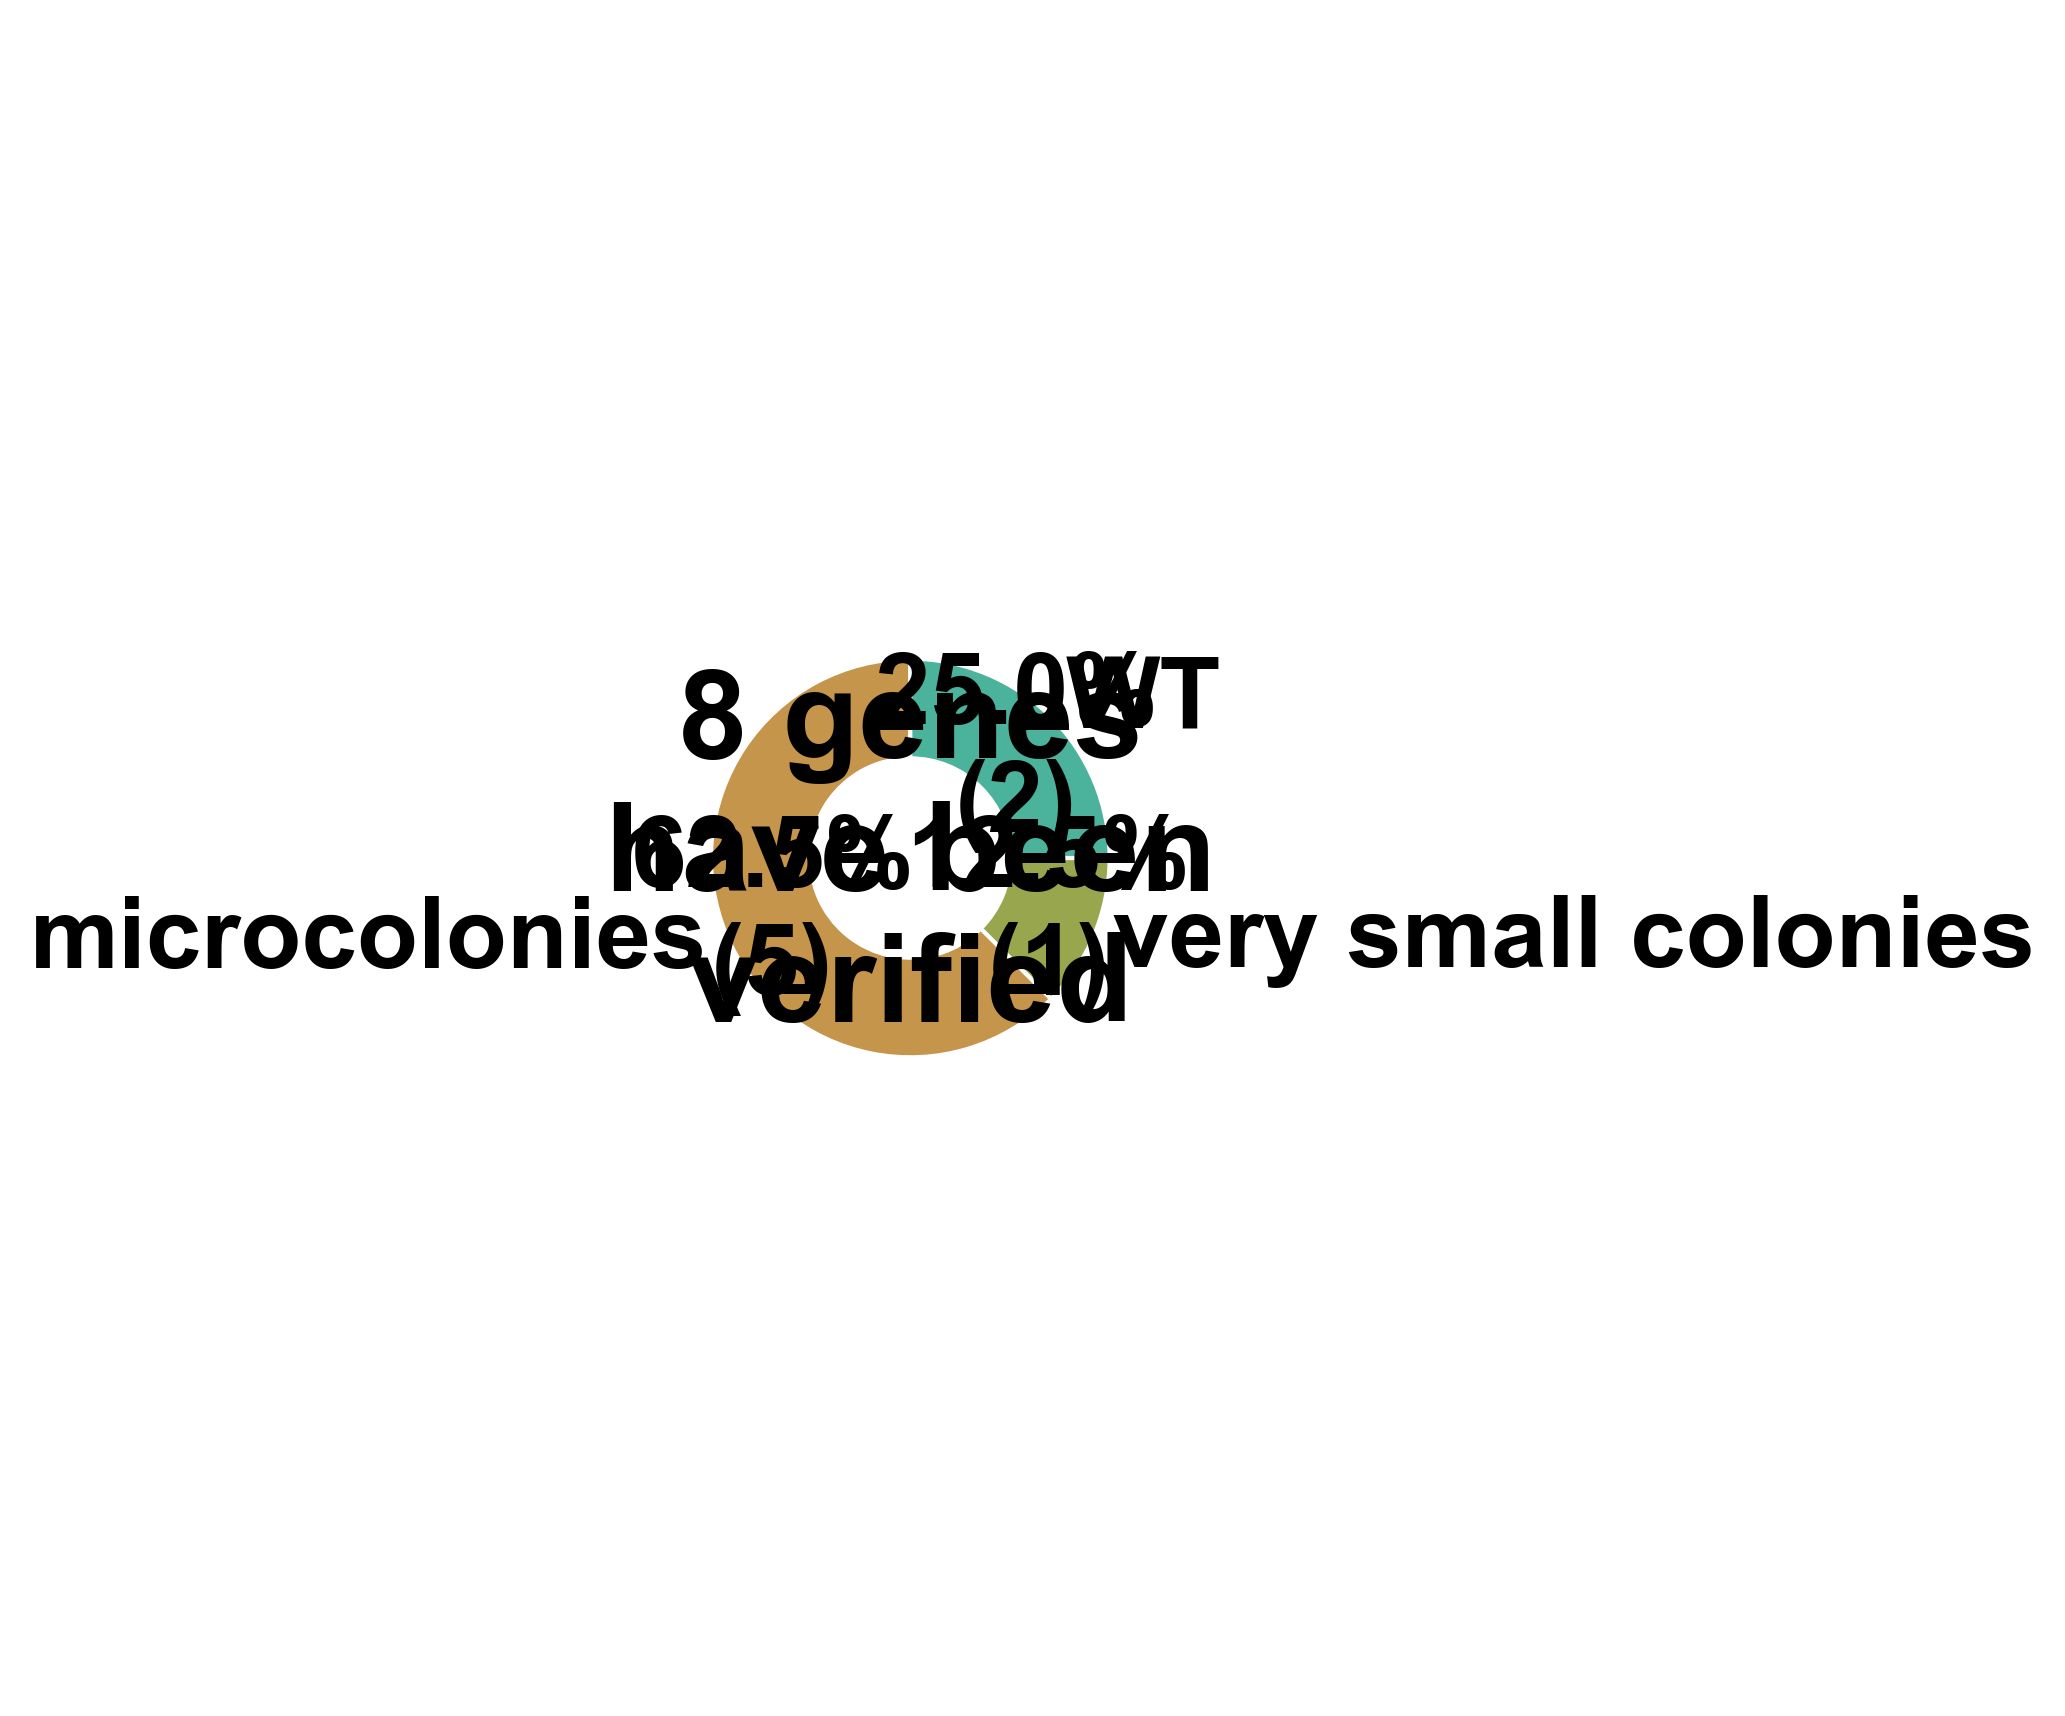

In [17]:
donut_chart_for_verification_results(WT2nonWT_um_dict, "WT2nonWT_verification_donut_chart.pdf")
donut_chart_for_verification_results(sc2E_um_dict, "small_colonies_to_E_verification_donut_chart.pdf")
donut_chart_for_verification_results(E2V_um_dict, "E2V_verification_donut_chart.pdf")